In [5]:
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset
import pytorch_lightning as pl
from pytorch_lightning.plugins import DDPPlugin
from torch import nn

from embed_structure_model import trans_basic_block, trans_basic_block_Config
from tm_vec_utils import featurize_prottrans, embed_tm_vec, cosine_similarity_tm

from transformers import T5EncoderModel, T5Tokenizer
import re
import gc

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns 

from Bio import SeqIO
import gzip

from numpy import dot
from numpy.linalg import norm

import seaborn as sns

import pickle

In [6]:
#Load the ProtTrans model and ProtTrans tokenizer
tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50", do_lower_case=False )
model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50")
gc.collect()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model = model.eval()

Some weights of the model checkpoint at Rostlab/prot_t5_xl_uniref50 were not used when initializing T5EncoderModel: ['decoder.block.21.layer.1.layer_norm.weight', 'decoder.block.14.layer.0.layer_norm.weight', 'decoder.block.12.layer.2.layer_norm.weight', 'decoder.block.15.layer.2.layer_norm.weight', 'decoder.block.19.layer.0.SelfAttention.k.weight', 'decoder.block.15.layer.0.SelfAttention.k.weight', 'decoder.block.1.layer.2.DenseReluDense.wo.weight', 'decoder.block.11.layer.0.SelfAttention.v.weight', 'decoder.block.14.layer.2.DenseReluDense.wo.weight', 'decoder.block.23.layer.0.SelfAttention.q.weight', 'decoder.block.9.layer.1.EncDecAttention.v.weight', 'decoder.block.10.layer.2.layer_norm.weight', 'decoder.block.4.layer.0.layer_norm.weight', 'decoder.block.13.layer.1.EncDecAttention.v.weight', 'decoder.block.19.layer.1.EncDecAttention.v.weight', 'decoder.block.5.layer.2.DenseReluDense.wo.weight', 'decoder.block.9.layer.2.layer_norm.weight', 'decoder.block.17.layer.0.layer_norm.weight'

In [7]:
#TM-Vec model paths
tm_vec_model_cpnt = "/mnt/home/thamamsy/ceph/deepblast/models/transformer_lr0.0001_dmodel1024_nlayer2_datasample_45_thresh_300_pairs_in_folds_included_23M_normal_tmax/checkpoints/last.ckpt"
tm_vec_model_config = "/mnt/home/thamamsy/ceph/deepblast/models/transformer_lr0.0001_dmodel1024_nlayer2_datasample_45_thresh_300_pairs_in_folds_included_23M_normal_tmax/params.json"
#tm_vec_model_cpnt = '/mnt/home/thamamsy/ceph/deepblast/models/transformer_lr0.000075_dmodel1024_nlayer2_all_pairs_tm_sample_95percent_141Mtest/checkpoints/epoch=3-step=1490999-val_loss=0.0272.ckpt'
#tm_vec_model_config = '/mnt/home/thamamsy/ceph/deepblast/models/transformer_lr0.000075_dmodel1024_nlayer2_all_pairs_tm_sample_95percent_141Mtest/params.json'

#Load the TM-Vec model
tm_vec_model_config = trans_basic_block_Config.from_json(tm_vec_model_config)
model_deep = trans_basic_block.load_from_checkpoint(tm_vec_model_cpnt, config=tm_vec_model_config)
model_deep = model_deep.to(device)
model_deep = model_deep.eval()

In [8]:
#Load some example sequences-> use Malidup here
sequence_df = pd.read_csv("/mnt/home/thamamsy/ceph/deepblast/data/malidup_sequences_and_tm_scores.csv")

In [9]:
tm_score_predictions = []
for i in range(sequence_df.shape[0]):
    sequence_1 = sequence_df.loc[i, 'Sequence 1']
    sequence_2 = sequence_df.loc[i, 'Sequence 2']
    
    sequence_1 = np.expand_dims(sequence_1, axis=0)
    sequence_2 = np.expand_dims(sequence_2, axis=0)
    
    #Featurize sequence 1 and 2 using ProtTrans
    protrans_sequence_1 = featurize_prottrans(sequence_1, model, tokenizer, device).detach()
    protrans_sequence_2 = featurize_prottrans(sequence_2, model, tokenizer, device).detach()

    #Embed sequence 1 and 2 using TM-Vec, applied to the ProtTrans features
    embedded_sequence_1 = embed_tm_vec(protrans_sequence_1, model_deep, device)
    embedded_sequence_2 = embed_tm_vec(protrans_sequence_2, model_deep, device)
    
    #Predict the TM-score for sequence 1 and 2, using the TM-Vec embeddings
    predicted_tm_score = cosine_similarity_tm(torch.tensor(embedded_sequence_1), torch.tensor(embedded_sequence_2))
    
    tm_score_predictions.append(predicted_tm_score)

<AxesSubplot:xlabel='tm_max', ylabel='tm_score_predictions'>

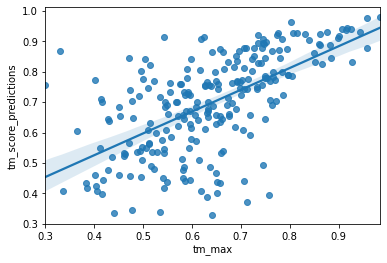

In [11]:
#Visualize our TM-score predictions versus the ground truth TM-scores
sequence_df['tm_score_predictions'] = np.array(tm_score_predictions)
sns.regplot(data=sequence_df, x="tm_max", y="tm_score_predictions")